In [1]:
%cat map_generator.py

#!/usr/bin/python3

import json
import random
import argparse
from copy import copy
from math import sqrt

arg_parser = argparse.ArgumentParser(description='Generator of maps using perlin noise.')
arg_parser.add_argument('-i', '--side', default=50, help='length of side of map')
arg_parser.add_argument('-t', '--step', default=20, help='step between each vertex of map')
arg_parser.add_argument('-o', '--smoothness', default=25., help='smoothness of the map (more is more smooth)')
arg_parser.add_argument('-e', '--seed', default=None, help='seed for random number generator')
arg_parser.add_argument('-s', '--sea', default=100, help='sea level of the map')
arg_parser.add_argument('-m', '--max', default=250, help='maximum of the map')
args = arg_parser.parse_args()


# Yes, I'm writing my own vectors in 2017.
class Vec2D:
    def __init__(self, x: float, y: float) -> None:
        self.x = float(x)
        self.y = float(y)

    def __mul__(self, other):
        return (self.x * other.x) + (se

```python
# Yes, I'm writing my own vectors in 2017.
class Vec2D:
    ...

```

No you don't :p

In [4]:
import numpy as np

```python
gradient = [
        Vec2D(unit, unit),
        Vec2D(unit, -unit),
        Vec2...
```

Why so few possible gradients ?

```python
# construction of a shuffled list of 512 elements distributed from 0-255
    perms = [i for i in range(256)]
    random.shuffle(perms)
    permutable = [perms[i & 255] for i in range(512)]
```

Meh, that's just twice a permutation of [[0, 255]]...

Time to sleep !

---

Let me try :

First, let's define the map and its grid.

In [5]:
n = 2 #size (both width and height) of the grid
m = 64 #size of each subarray
N = n*m #size of the final map

grid = np.zeros((n+1, n+1, 2), dtype=np.float32)
    #we need n+1 to get the border nodes
    #third dimension is used to store gradient vectors

final_grid = np.zeros((N, N), dtype=np.float32)

Now, we want random vectors uniformly sampled on the unit circle. That's trivial with an angle (draw uniformly $\theta$ in $[0, 2\pi]$), but let's try a method that works in any $d$-dimensional space :

+ First we draw a uniform sample in the unit cube (simply draw each coordinate in [-1, 1])
+ Then we trim samples outside the unit ball (defined by euclidean norm)
+ Finally, we can project the results onto the unit sphere

A minor drawback : the obtained sample has not a deterministic size

In [6]:
#in our case :
d = 2

#let's generate a bit too much
cube_bag = np.random.uniform(
    low = -1.,
    high = 1.,
    size = (4*(n+1)**2, d) #4 times the necessary amount
)

In [7]:
cube_bag.shape

(36, 2)

In [8]:
#remove extra-spherical points
keepFilter = (np.linalg.norm(cube_bag, axis=1) <= 1.)
ball_bag = cube_bag[keepFilter]

In [9]:
ball_bag.shape

(27, 2)

In [10]:
#project onto the sphere
norms = np.linalg.norm(ball_bag, axis=1)
sphere_bag = (ball_bag.T / norms).T

In [11]:
sphere_bag.shape

(27, 2)

In [12]:
#sample our desired gradients from this bag
keepIdx = np.random.choice(
    sphere_bag.shape[0],
    size = (n+1)**2, 
    replace = False
)

gradients = sphere_bag[keepIdx]

In [13]:
gradients.shape

(9, 2)

In [14]:
#instead of filling `grid` we can replace it
grid = gradients.reshape((n+1,n+1,2))

In [15]:
grid.shape

(3, 3, 2)

Okay so now we've got our gradients. Rest of your code was good :)

In [16]:
from numpy.linalg import norm

def normalize(v):
    vnorm = norm(v)
    if vnorm == 0:
        return v
    return v / vnorm

interpolation_fn = lambda x: (3 * (x ** 2)) - (2 * (x ** 3))

def perlin_noise(x: int, y: int):
    
    ix0, iy0 = x // m, y // m
    x0, y0 = ix0 * m, iy0 * m

    dist_s = np.array([x - x0, y - y0])
    dist_t = np.array([x - x0 - m, y - y0])
    dist_u = np.array([x - x0, y - y0 - m])
    dist_v = np.array([x - x0 - m, y - y0 - m])
    
    s = grid[ix0, iy0].dot(normalize(dist_s))
    t = grid[ix0 + 1, iy0].dot(normalize(dist_t))
    u = grid[ix0, iy0 + 1].dot(normalize(dist_u))
    v = grid[ix0 + 1, iy0 + 1].dot(normalize(dist_v))

    mantissa_x = (x - x0) / m
    Cx = interpolation_fn(mantissa_x)

    Li1 = s + Cx * (t-s)
    Li2 = u + Cx * (v-u)

    mantissa_y = (y - y0) / m
    Cy = interpolation_fn(mantissa_y)
    return Li1 + Cy * (Li2 - Li1)

In [17]:
for i in range(final_grid.shape[0]):
    for j in range(final_grid.shape[1]):
        
        final_grid[i,j] = perlin_noise(i,j)

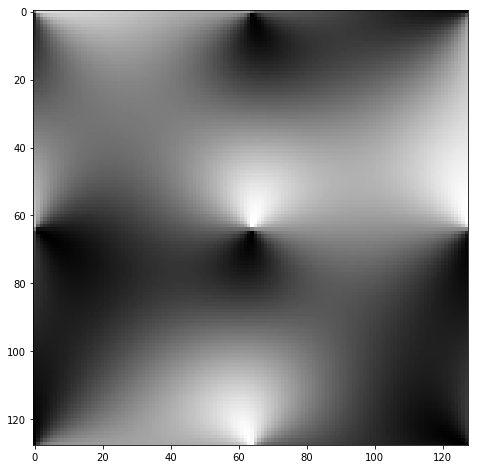

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12.,8.]

plt.imshow(final_grid, cmap='gray');

In [239]:
final_grid.max()

0.99997288

In [240]:
final_grid.min()

-0.99992061

Actually, its not working as I'd expected. Are gradients still bugged ?